<h1>Data Loading and Cleaning</h1>

Import required libraries.

In [1]:
import pandas as pd
import numpy as np
from statsmodels import robust

Data based on [2019 List of Charities](https://open.canada.ca/data/en/dataset/d4287672-3253-4bb8-84c7-4e515ea3fddf/resource/8d011273-894e-4834-8d22-60075c1c2beb?inner_span=True).

List of selected columns:

In [2]:
id_cols = ['BN', 'Category', 'Province', 'Country']
fin_cols = ['BN', 'Section Used', '5000', '5050', '5100']

Read CSV files: charity identification and financial data.

In [3]:
ident = pd.read_csv('2019_ident.csv', usecols=id_cols)
ident.head()

,BN,Category,Province,Country
0,106693120RR0001,11,AB,CA
1,108197633RR0001,30,NB,CA
2,108219650RR0001,110,ON,CA
3,118799154RR0001,210,ON,CA
4,119033702RR0001,200,ON,CA


"Section Used" refers to the filing document used, with [Schedule 6](https://www.canada.ca/en/revenue-agency/services/forms-publications/publications/t4033/t4033-completing-registered-charity-information-return.html#_Toc412013150) being a more detailed format used for charities that exceed certain criteria for revenue and property.

Column numbers of the financial CSV refer to Lines of the T3010 Registered Charity Information Return tax form, with amounts in Canadian Dollars:

* 5000: "Total charitable programs expenditures included in line 4950"
* 5050: "Total gifts to qualified donees excluding enduring property and specified gifts"
* 5100: "Total expenditures"

In [4]:
finance = pd.read_csv('2019_financial.csv', usecols=fin_cols)
finance.head()

,BN,Section Used,5000,5050,5100
0,106693120RR0001,6,94123.0,NaN,94123.0
1,108197633RR0001,D,NaN,NaN,NaN
2,108219650RR0001,6,1698.0,34600.0,37545.0
3,118799154RR0001,D,NaN,NaN,NaN
4,119033702RR0001,D,2859.0,NaN,3119.0


Join finance and identification data on charity identifiers BN found in both dataframes.

In [5]:
df = pd.merge(ident, finance, on='BN')
df.head()

,BN,Category,Province,Country,Section Used,5000,5050,5100
0,106693120RR0001,11,AB,CA,6,94123.0,NaN,94123.0
1,108197633RR0001,30,NB,CA,D,NaN,NaN,NaN
2,108219650RR0001,110,ON,CA,6,1698.0,34600.0,37545.0
3,118799154RR0001,210,ON,CA,D,NaN,NaN,NaN
4,119033702RR0001,200,ON,CA,D,2859.0,NaN,3119.0


Vast majority of charities are in Canada. Limiting analysis to such entities simplifies the province visualization.

In [6]:
df['Country'].value_counts()

CA    83496
US       24
GB        1
Name: Country, dtype: int64

In [7]:
df = df[df['Country'] == 'CA']
df.shape

(83496, 8)

Overhead based on comparing total expenditure to program spending and qualified gifts, compare Lines 5000 and 5050 to 5100.

In [8]:
overhead = (1 - ((df['5000'] + df ['5050'])/df['5100'])) * 100
df = df.assign(Overhead = overhead)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset = ['Overhead'], inplace = True)
df.head()

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
2,108219650RR0001,110,ON,CA,6,1698.0,34600.0,37545.0,3.321348
7,132410671RR0097,1,QC,CA,D,91.0,19718.0,20890.0,5.174725
15,806138780RR0001,50,ON,CA,D,22484.0,0.0,26388.0,14.794604
18,817213697RR0001,30,ON,CA,6,6806.0,1600.0,8663.0,2.966640
22,834522435RR0001,1,MB,CA,6,56958.0,3000.0,59958.0,0.000000


In [9]:
df['Overhead'].describe()

count    22599.000000
mean         7.705262
std        313.638092
min     -32223.000000
25%          1.100606
50%          7.572503
75%         21.724067
max        289.363999
Name: Overhead, dtype: float64

Note presence of negative overhead values. These seem to be due to errors in inputting tax form information, such as with repeated entries for program spending and qualified gifts. May be best to drop such rows.

In [10]:
df[df['Overhead'] < 0].head()

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
140,119256600RR0001,60,BC,CA,D,7375.0,7375.0,8349.0,-76.667864
192,897120333RR0001,180,YT,CA,D,3228.0,1643.0,3228.0,-50.898389
340,861098895RR0001,100,SK,CA,D,24372.0,22090.0,24454.0,-89.997546
389,118850502RR0001,200,BC,CA,D,4020.0,32163.0,32163.0,-12.498834
416,139138465RR0001,1,ON,CA,6,195.0,195.0,195.0,-100.000000


In [11]:
df = df[df['Overhead'] >= 0]
df.shape

(21475, 9)

<AxesSubplot:ylabel='Overhead Percentage'>

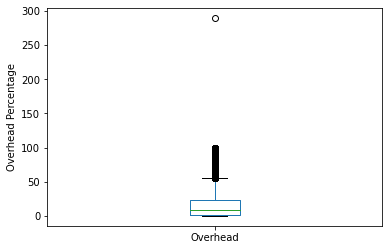

In [12]:
df['Overhead'].plot.box(ylabel='Overhead Percentage')

In [13]:
df[df['Overhead'] > 100]

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
44057,839603305RR0001,210,AB,CA,6,7418.0,68000.0,-39827.0,289.363999


Outlier with maximum overhead value above 100% clearly has wrong entries: negative total expenses with a high gift expense. Need to drop.

In [14]:
df = df[df['Overhead'] <= 100]
df.shape

(21474, 9)

<h1>Overhead by Section Used</h1>

Minimal difference in the mean overhead for both types of organizations, but large when medians are considered.

In [15]:
sections = df.groupby('Section Used', as_index=False).mean()
print(sections[['Section Used','Overhead']])

sections = df.groupby('Section Used', as_index=False).median()
sections[['Section Used','Overhead']]

  Section Used   Overhead
0            6  18.899589
1            D  16.424937


,Section Used,Overhead
0,6,10.110869
1,D,3.619474


Due to the long right tails of the distributions (see [Appendix](#SUd)), the median and the median absolute deviation (MAD) will be used to compare the two categories. Schedule 6 charities had higher median overhead percentages and deviation.

<AxesSubplot:xlabel='Section Used'>

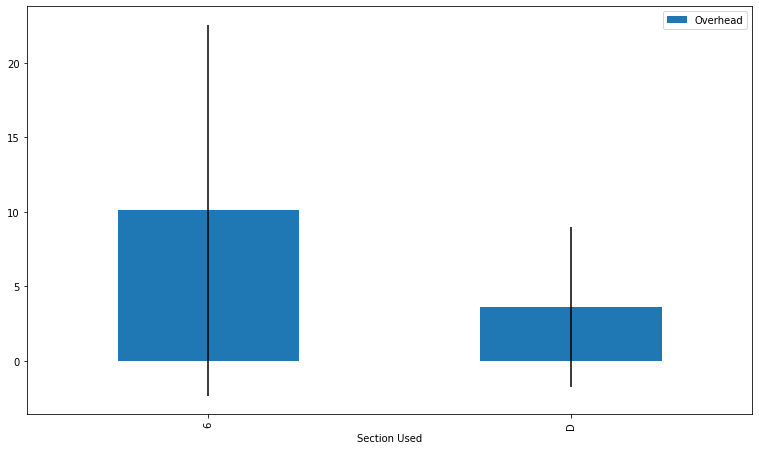

In [41]:
serr = df.groupby('Section Used')['Overhead'].apply(robust.mad)

sections.plot.bar(
    'Section Used', 
    'Overhead', 
    yerr = serr, 
    figsize=(13,7.5))

<h1>Overhead by Province of Charity</h1>

Most provinces similar in distribution of overhead percentages, except for Nunavut at the low end and Yukon at the high one. This may simply be due to a smaller count of charities compared to other provinces (see [Appendix](#Poi)).

<AxesSubplot:xlabel='Province'>

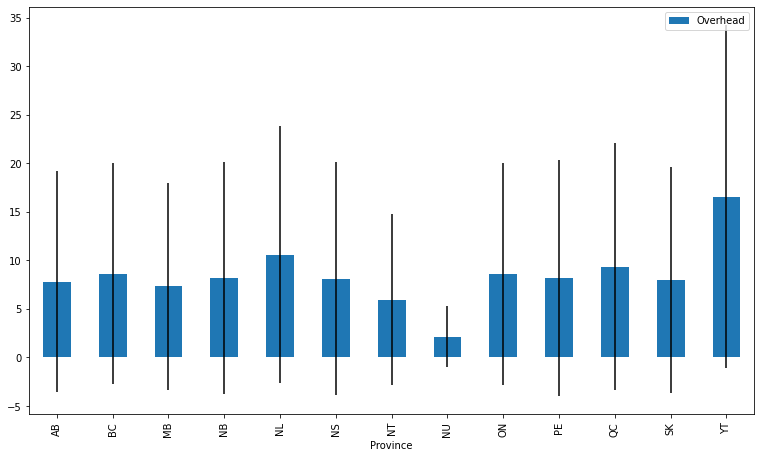

In [37]:
provinces = df.groupby('Province', as_index=False).median()
perr = df.groupby('Province')['Overhead'].apply(robust.mad)

provinces.plot.bar(
    'Province', 
    'Overhead', 
    yerr = perr,
    figsize=(13,7.5))

<h1>Overhead by Category of Charity</h1>

Charities were categorized numerically according to their field of work, e.g. 0001 corresponding to "Organizations Relieving Poverty". Medians and variances were roughly similar except for some categories:
* Religious organizations (Categories 30 - 90) had the lowest median overheads. Of particular note are charities that are Christian (30) and non-Abrahamic (60, "Other Religions).
* Of the main group of charities with median overheads below 20%, "Core Health Care" (Category 100) was the highest being just under that threshold.
* Categories 155, 175, and 215 had unusual deviations due to the smaller number of entities involved (see [Appendix](#Coi)).

<AxesSubplot:xlabel='Category'>

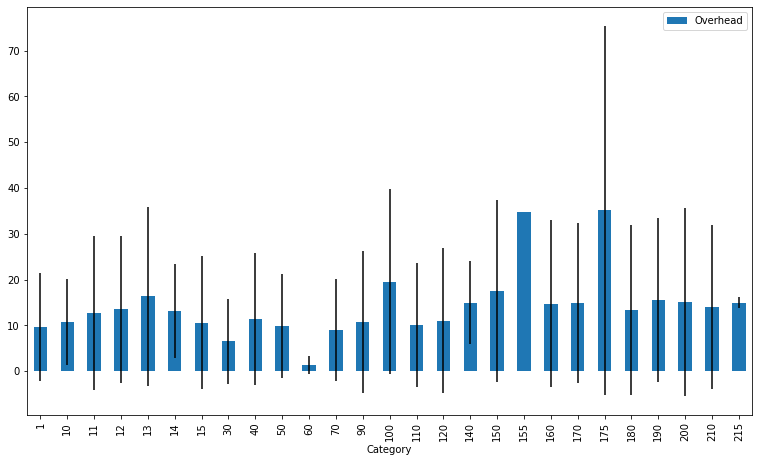

In [38]:
categories = df.groupby('Category', as_index=False).median()
cerr = df.groupby('Category')['Overhead'].apply(robust.mad)

categories.plot.bar(
    'Category', 
    'Overhead', 
    yerr = cerr, 
    figsize=(13,7.5))

<h1>Appendix</h1>

<h4>Section Used distributions</h4>
<a id='SUd'></a>

Similar shape for both distributions.

Section Used
6    AxesSubplot(0.125,0.125;0.775x0.755)
D    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Overhead, dtype: object

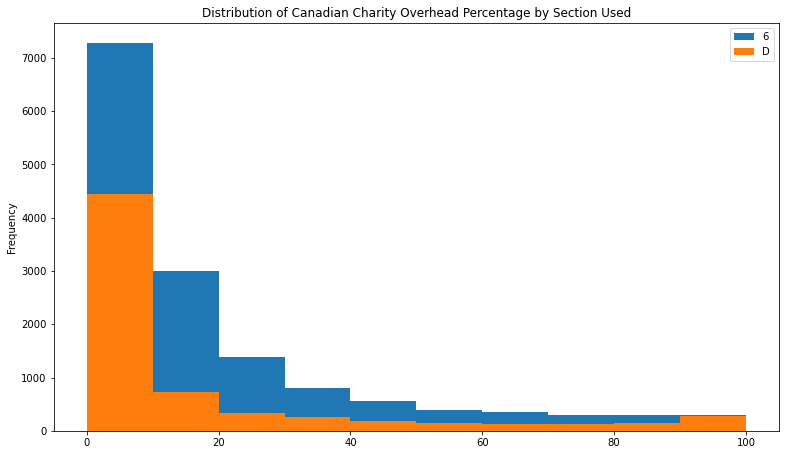

In [35]:
section = df.groupby('Section Used')['Overhead']

section.plot.hist(
    by='Overhead', 
    title='''Distribution of Canadian Charity Overhead Percentage by Section Used''', 
    legend=1,
    figsize=(13,7.5))

<h4>Provinces of interest</h4>
<a id='Poi'></a>

<AxesSubplot:>

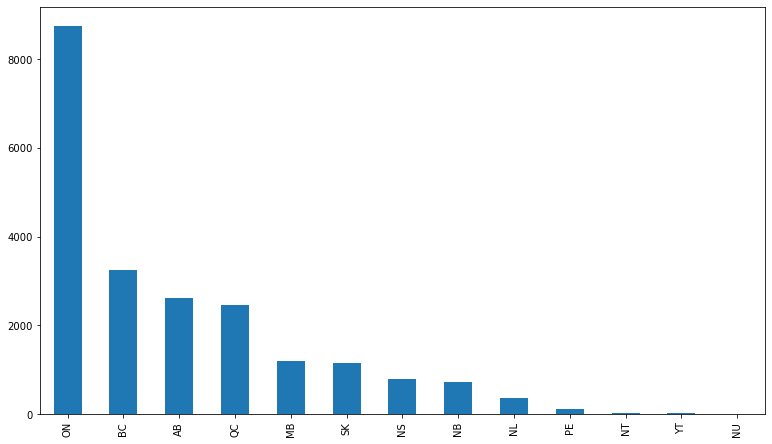

In [39]:
df['Province'].value_counts().plot.bar(figsize=(13,7.5))

**Nunavut**: Note how all double-digit percentage overheads are found in Schedule 6 organizations.

In [21]:
df[df['Province'] == 'NU']

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
1481,810143925RR0001,1,NU,CA,6,914413.0,0.0,1072933.0,14.774455
2019,897090536RR0001,200,NU,CA,6,658962.0,0.0,836139.0,21.189898
14868,861547230RR0001,160,NU,CA,6,1691491.0,0.0,1691491.0,0.000000
29023,764942280RR0001,30,NU,CA,D,5675.0,7068.0,12836.0,0.724525
44680,840564223RR0001,30,NU,CA,D,16976.0,4950.0,22406.0,2.142283
51531,866896228RR0001,30,NU,CA,6,158157.0,25264.0,186198.0,1.491423
58840,816624142RR0001,1,NU,CA,6,140206.0,16231.0,182176.0,14.128645
63862,887332591RR0001,30,NU,CA,D,28551.0,6051.0,36105.0,4.162858
70611,130402019RR0022,30,NU,CA,D,45437.0,0.0,45437.0,0.000000


**Yukon**: Decent proportion of charities with double-digit overhead percentages.

In [22]:
df[df['Province'] == 'YT']

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
2059,123034464RR0001,1,YT,CA,6,594067.0,0.0,730292.0,18.653498
3074,890308448RR0001,60,YT,CA,D,12431.0,19255.0,31686.0,0.000000
13993,890660947RR0001,160,YT,CA,D,1297.0,0.0,2171.0,40.257946
27522,131494726RR0001,30,YT,CA,6,106087.0,14840.0,224487.0,46.131847
27528,764962882RR0001,30,YT,CA,D,20720.0,9122.0,29968.0,0.420448
28301,119307916RR0001,15,YT,CA,6,212278.0,27299.0,319906.0,25.110189
29882,119208031RR0003,30,YT,CA,D,2870.0,2870.0,68200.0,91.583578
39376,118913318RR0001,30,YT,CA,D,5100.0,5100.0,22422.0,54.508964
40701,108206798RR0001,30,YT,CA,6,322228.0,36530.0,454558.0,21.075418
40920,118804509RR0001,30,YT,CA,6,642321.0,70102.0,852408.0,16.422300


<h4>Categories of interest.</h4>
<a id='Coi'></a>

<AxesSubplot:>

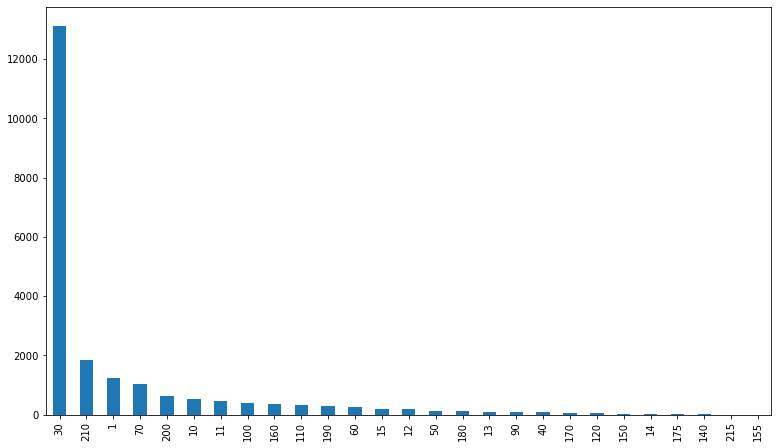

In [40]:
df['Category'].value_counts().plot.bar(figsize=(13,7.5))

Single charity identified for Category 155: **"Upholding Human Rights".**

In [24]:
df[df['Category'] == 155]

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
56847,118777267RR0001,155,QC,CA,D,40270.0,2000.0,64849.0,34.817808


Charities identified for Category 175: **"Agriculture"**. Note how majority of entities have overheads with double-digit percentages.

In [25]:
df[df['Category'] == 175]

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
16589,870150968RR0001,175,ON,CA,D,18835.0,100.0,20407.0,7.213211
21822,119229557RR0001,175,AB,CA,6,134037.0,2700.0,146124.0,6.423996
22983,129820023RR0001,175,AB,CA,6,831657.0,0.0,903917.0,7.994097
26843,118867167RR0001,175,ON,CA,6,120277.0,32210.0,249116.0,38.788757
29249,897454625RR0001,175,AB,CA,D,0.0,3234.0,163483.0,98.021813
29368,876200700RR0001,175,ON,CA,6,5192.0,725.0,20691.0,71.403025
30342,127186138RR0001,175,ON,CA,6,156174.0,1225.0,284874.0,44.747853
31195,895885911RR0001,175,ON,CA,D,10159.0,200.0,15982.0,35.183331
31293,868559279RR0001,175,ON,CA,6,4366.0,798.0,8689.0,40.568535
32265,843277146RR0001,175,ON,CA,D,35751.0,0.0,37284.0,4.111683


Two charities identified for Category 215: **NASOs (National Art Service Organizations).**

In [26]:
df[df['Category'] == 215]

,BN,Category,Province,Country,Section Used,5000,5050,5100,Overhead
57552,758166714RR0001,215,ON,CA,6,169191.0,40000.0,248316.0,15.756133
68245,100762590RR0001,215,ON,CA,6,3434736.0,10802.0,4015370.0,14.191270


<h1>Testing cells.</h1>

In [36]:
provinces

,Province,Category,5000,5050,5100,Overhead
0,AB,30,83655.0,11314.0,158259.0,7.786515
1,BC,30,87319.5,12378.5,154638.0,8.627092
2,MB,30,76974.0,13394.0,131377.0,7.305550
3,NB,30,57794.0,9314.0,108625.0,8.176723
4,NL,30,102798.0,7362.5,142446.0,10.587189
5,NS,30,46268.0,5355.0,83468.0,8.116776
6,NT,30,55280.0,18564.0,160058.0,5.949832
7,NU,30,140206.0,4950.0,182176.0,2.142283
8,ON,30,96154.5,14148.5,164574.0,8.567141
9,PE,30,67711.0,6952.0,121465.0,8.196015
